# Lecture 4: Bias-Variance Tradeoff & Cross-Validation

This notebook demonstrates the concepts of **Bias**, **Variance**, and **Cross-Validation** using a k-Nearest Neighbors (kNN) classifier on a synthetic dataset.

## Goals:
1.  **Visualize the Dataset**: Understand the underlying structure (Gaussian mixtures (optional)).
2.  **Optimal Decision Boundary**: See the best possible classification boundary (Bayes Error (optional)).
3.  **Variance**: Visualize how the decision boundary changes with different training sets.
4.  **Hyperparameter Tuning (Holdout)**: Find optimal $k$ using a simple training/validation split.
5.  **K-Fold Cross-Validation**: Perform robust model evaluation using `cross_val_score`.
6.  **Error Curves**: Plot training vs validation error as $k$ changes.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm

# Sklearn imports
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

# Set random seed for reproducibility
np.random.seed(42)


## 0. For in class demo (you can skip this part)

---
### 1. Data Generation

We generate a synthetic binary classification dataset using a mixture of Gaussians. This allows us to have some overlap between classes, simulating noise.

In [2]:
def generate_data(params_class0, params_class1, n_samples_class0=1000, n_samples_class1=1000):
    """
    Generates a dataset with two classes, each as a mixture of Gaussians.
    """
    # Generate data for Class 0
    X_class0_list = []
    weights0 = [component['weight'] for component in params_class0]
    total_weight0 = sum(weights0)
    n_samples_components0 = [int(n_samples_class0 * (w / total_weight0)) for w in weights0]
    n_samples_components0[-1] += n_samples_class0 - sum(n_samples_components0)
    
    for n_samples_comp, component in zip(n_samples_components0, params_class0):
        X_comp = np.random.multivariate_normal(
            mean=component['mean'],
            cov=component['cov'],
            size=n_samples_comp
        )
        X_class0_list.append(X_comp)
    X_class0 = np.vstack(X_class0_list)
    y_class0 = np.zeros(len(X_class0))
    
    # Generate data for Class 1
    X_class1_list = []
    weights1 = [component['weight'] for component in params_class1]
    total_weight1 = sum(weights1)
    n_samples_components1 = [int(n_samples_class1 * (w / total_weight1)) for w in weights1]
    n_samples_components1[-1] += n_samples_class1 - sum(n_samples_components1)
    
    for n_samples_comp, component in zip(n_samples_components1, params_class1):
        X_comp = np.random.multivariate_normal(
            mean=component['mean'],
            cov=component['cov'],
            size=n_samples_comp
        )
        X_class1_list.append(X_comp)
    X_class1 = np.vstack(X_class1_list)
    y_class1 = np.ones(len(X_class1))
    
    # Combine and shuffle
    X = np.vstack((X_class0, X_class1))
    y = np.hstack((y_class0, y_class1))
    X, y = shuffle(X, y, random_state=42)
    
    return X, y

# Define mixture components
params_class0 = [{'mean': [-1.25, 0], 'cov': [[1.5, 0], [0, 1]], 'weight': 1.0}]
params_class1 = [
    {'mean': [1.25, 0], 'cov': [[1, 0], [0, 1]], 'weight': 0.9},
    {'mean': [-1, 3], 'cov': [[0.3, 0], [0, 0.3]], 'weight': 0.1},
]

print("Generating dataset...")
X, y = generate_data(params_class0, params_class1, n_samples_class0=500, n_samples_class1=500)
print(f"Dataset shape: {X.shape}, Labels: {len(y)} ({int(sum(y==0))} class 0, {int(sum(y==1))} class 1)")

Generating dataset...
Dataset shape: (1000, 2), Labels: 1000 (500 class 0, 500 class 1)


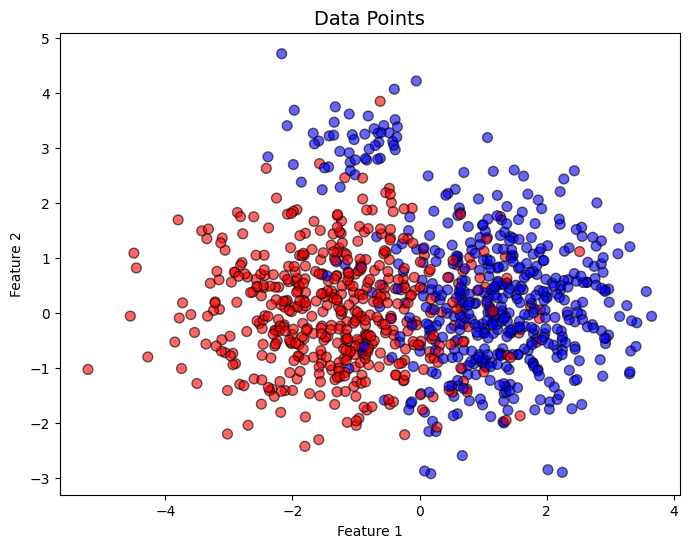

In [3]:
def plot_data_points(X, y):
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=50, alpha=0.6)
    plt.title('Data Points', fontsize=14)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

plot_data_points(X, y)

---
### 2. Optimal Decision Boundary

Since we know the true distributions (Gaussians), we can calculate the **Bayes Optimal Classifier**. No model can beat this performance on this specific problem.

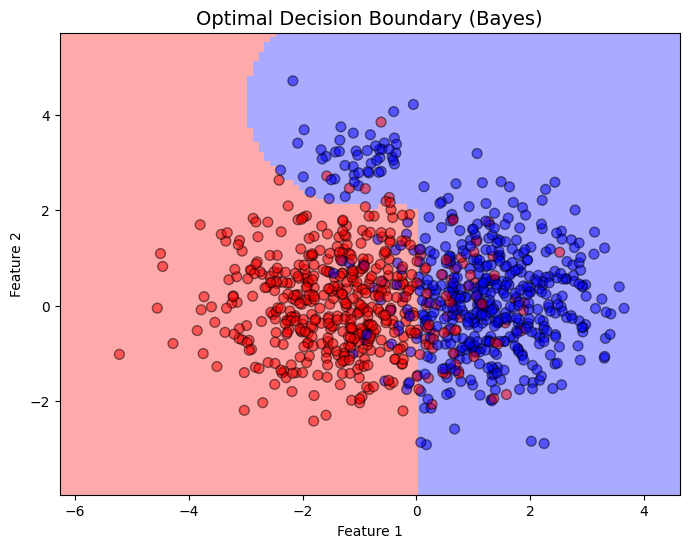

In [4]:
def plot_optimal_decision_boundary(params_class0, params_class1, X, y):
    from scipy.stats import multivariate_normal

    # Grid setup
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Compute PDFs
    def compute_pdf(params, points):
        pdf = np.zeros(len(points))
        total_weight = sum([comp['weight'] for comp in params])
        for comp in params:
            rv = multivariate_normal(mean=comp['mean'], cov=comp['cov'])
            pdf += (comp['weight'] / total_weight) * rv.pdf(points)
        return pdf

    pdf0 = compute_pdf(params_class0, grid_points)
    pdf1 = compute_pdf(params_class1, grid_points)

    # Prediction: Class 0 if P(0) > P(1)
    Z = np.where(pdf0 > pdf1, 0, 1).reshape(xx.shape)

    # Plot
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=50, alpha=0.5)
    plt.title('Optimal Decision Boundary (Bayes)', fontsize=14)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

plot_optimal_decision_boundary(params_class0, params_class1, X, y)

---
### 3. Visualizing Variance with Independent Training Sets

We divide the data into **disjoint subsets** (no overlap) and train a separate kNN model on each. Notice how the decision boundary varies - this is **Variance**.

In [5]:
def divide_into_disjoint_sets(X, y, n_sets=4):
    """
    Divide data into n_sets disjoint (non-overlapping) subsets.
    Uses random splitting to create disjoint subsets.
    
    Returns:
        List of (X_subset, y_subset) tuples
    """
    n_samples = len(y)
    
    # Shuffle indices first
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    # Split into n_sets disjoint parts
    set_size = n_samples // n_sets
    subsets = []
    
    for i in range(n_sets):
        start = i * set_size
        if i == n_sets - 1:
            end = n_samples  # Last set gets remaining samples
        else:
            end = start + set_size
        
        subset_indices = indices[start:end]
        subsets.append((X[subset_indices], y[subset_indices]))
    
    return subsets

# Demonstrate the split
subsets = divide_into_disjoint_sets(X, y, n_sets=4)
print(f"Divided {len(X)} samples into {len(subsets)} disjoint sets:")
for i, (X_sub, y_sub) in enumerate(subsets):
    print(f"  Set {i+1}: {len(X_sub)} samples ({int(sum(y_sub==0))} class 0, {int(sum(y_sub==1))} class 1)")

Divided 1000 samples into 4 disjoint sets:
  Set 1: 250 samples (115 class 0, 135 class 1)
  Set 2: 250 samples (121 class 0, 129 class 1)
  Set 3: 250 samples (121 class 0, 129 class 1)
  Set 4: 250 samples (143 class 0, 107 class 1)


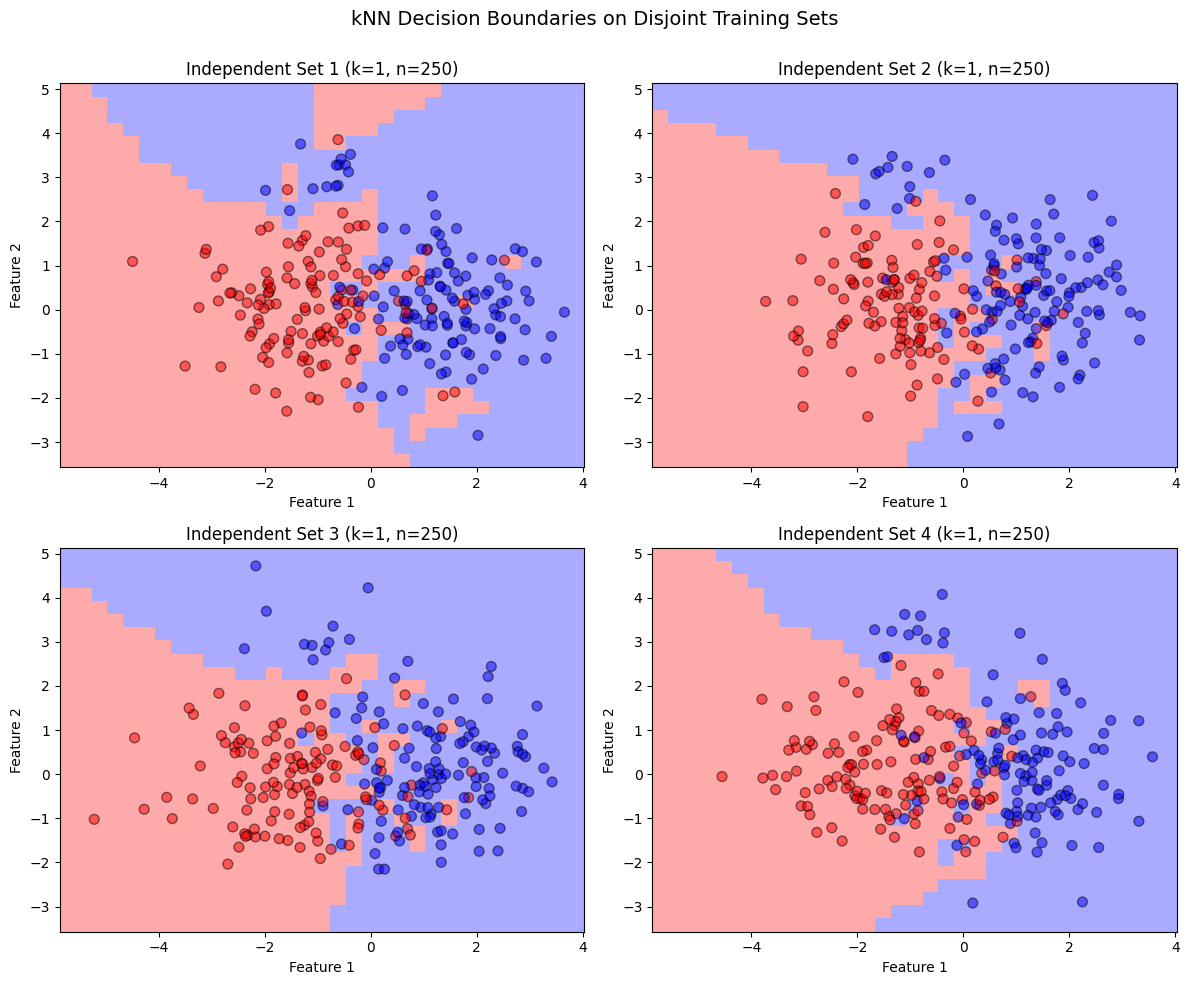

In [6]:
def plot_disjoint_boundaries(X, y, k=21, n_sets=4):
    """
    Plot kNN decision boundaries trained on DISJOINT (independent) subsets.
    Each training set has NO overlap with others.
    """
    subsets = divide_into_disjoint_sets(X, y, n_sets)
    
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()
    
    # Grid for plotting
    h = 0.3
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    for i, (X_train, y_train) in enumerate(subsets[:4]):
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train, y_train)
        
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        ax = axs[i]
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=50, alpha=0.5)
        ax.set_title(f"Independent Set {i+1} (k={k}, n={len(X_train)})")
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

    plt.suptitle(f'kNN Decision Boundaries on Disjoint Training Sets\n', fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize with k=21
plot_disjoint_boundaries(X, y, k=1, n_sets=4)

### 📝 Optional Activity: Compare Variance for Different k
Run the cell below to see how variance changes with different values of k.

k=1: High Variance (wiggly boundaries)


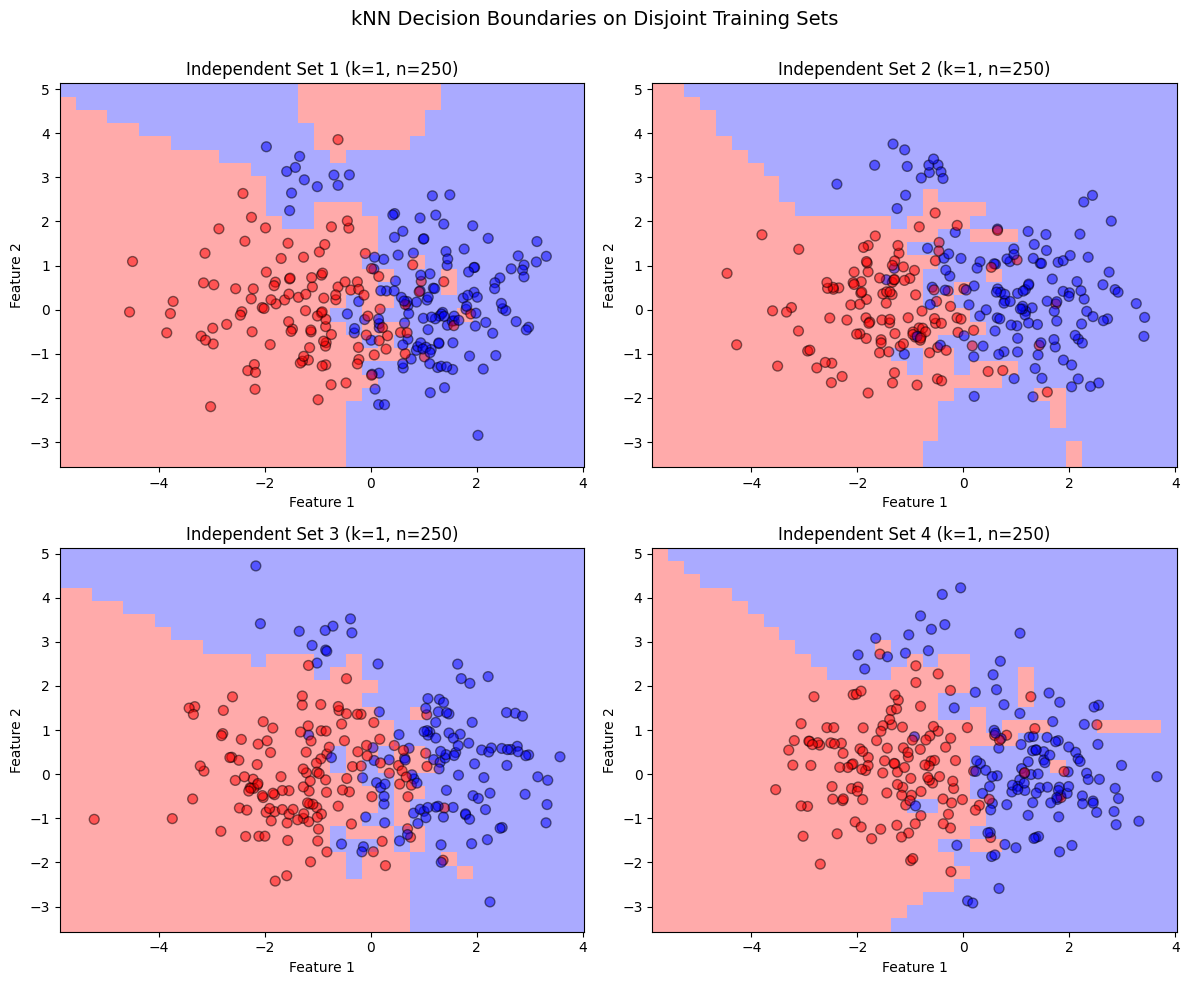


k=101: Low Variance (smooth, stable boundaries)


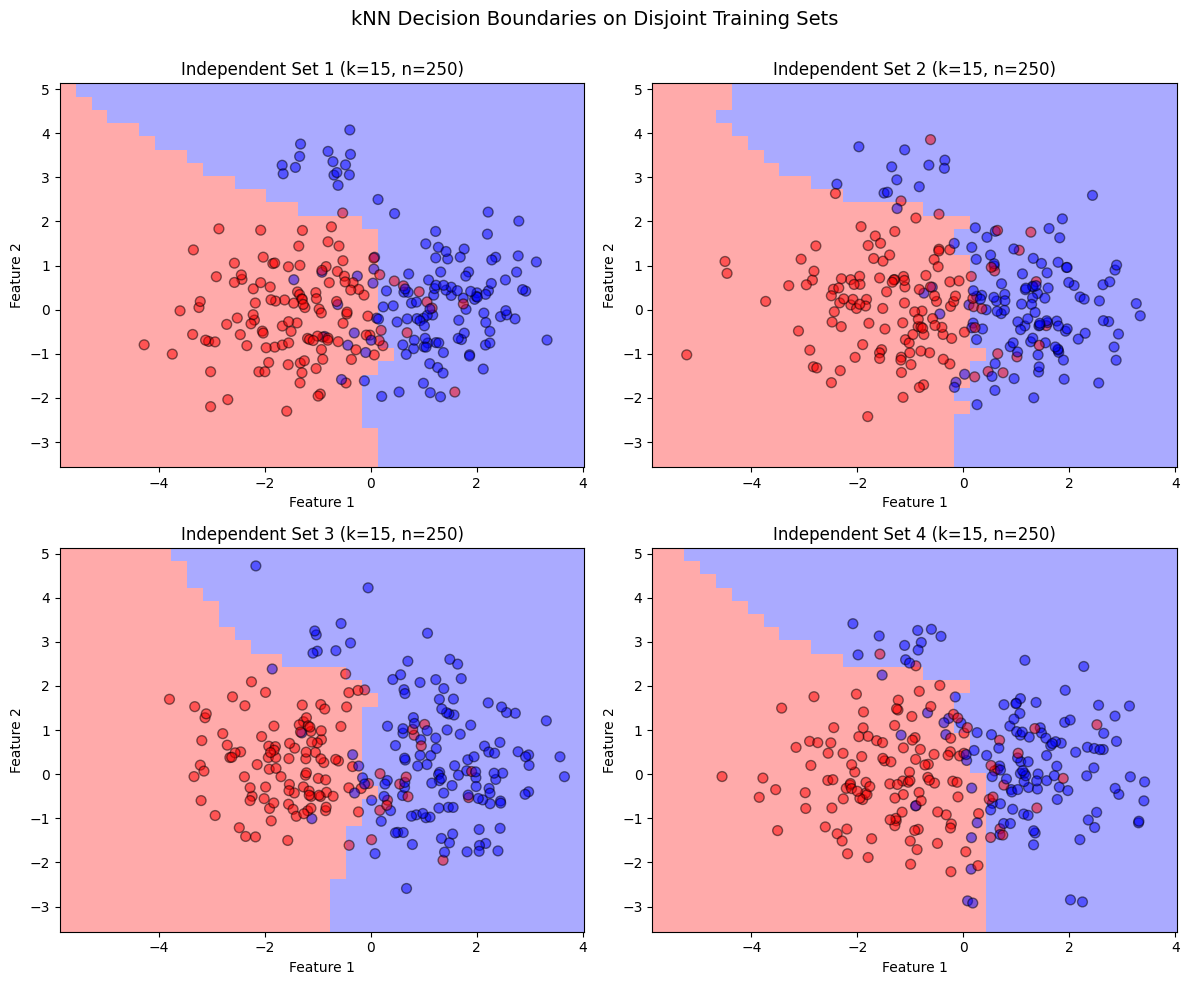


k=101: Low Variance (smooth, stable boundaries)


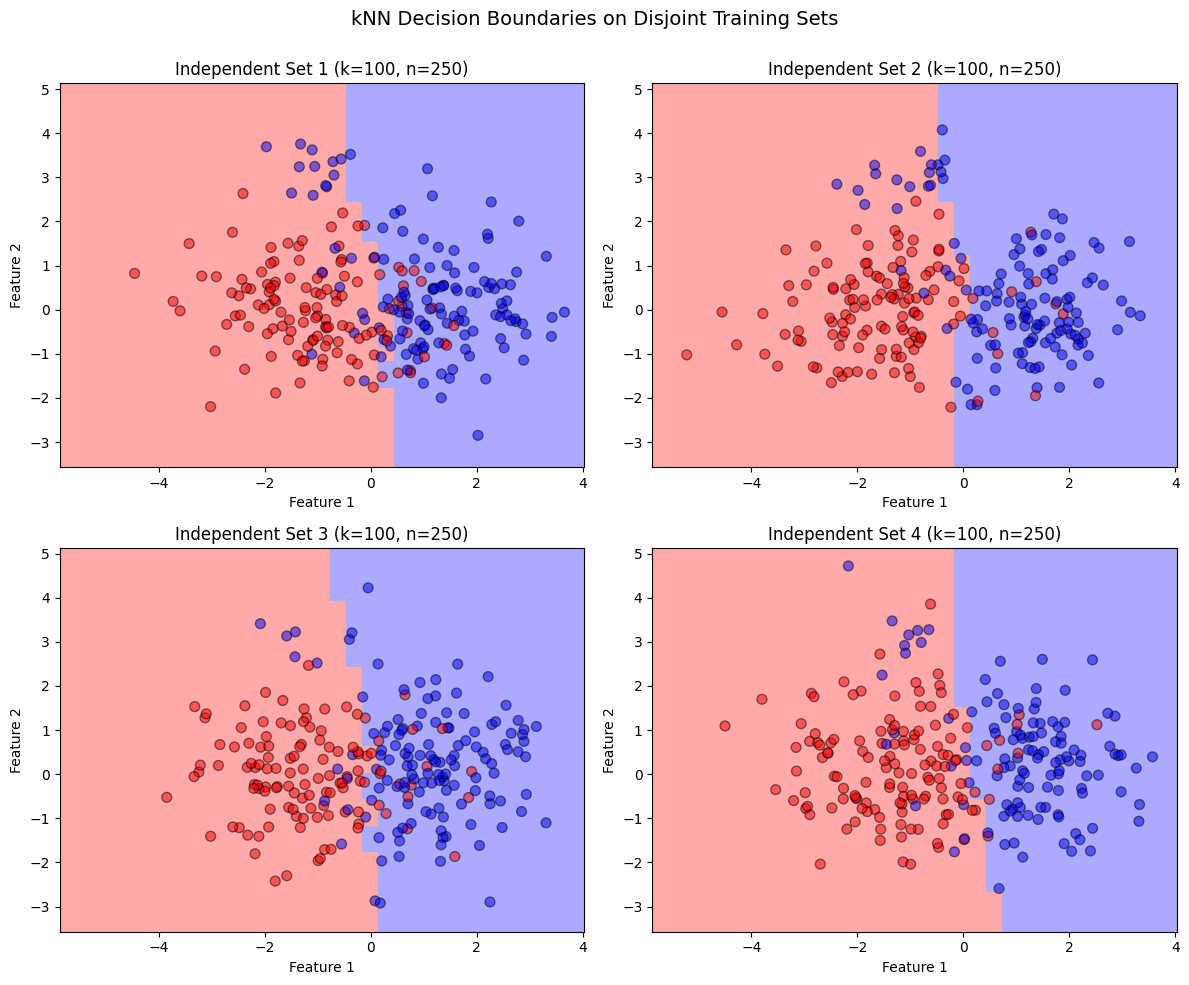

In [7]:
# Try k=1 (high variance) vs k=101 (low variance)
print("=" * 50)
print("k=1: High Variance (wiggly boundaries)")
print("=" * 50)
plot_disjoint_boundaries(X, y, k=1, n_sets=4)

print("\n" + "=" * 50)
print("k=101: Low Variance (smooth, stable boundaries)")
print("=" * 50)
plot_disjoint_boundaries(X, y, k=15, n_sets=4)

print("\n" + "=" * 50)
print("k=101: Low Variance (smooth, stable boundaries)")
print("=" * 50)
plot_disjoint_boundaries(X, y, k=100, n_sets=4)

---

## 1. Hyper-parameter Tuning via Train-Val-Test Split with sklearn

### KNeighborsClassifier and train_test_split

We are going to tune the parameter k for kNN using the validation set approach. Let's introduce the two key functions:

---

### `KNeighborsClassifier()` - k-Nearest Neighbors Classifier

**Purpose:** Create a k-Nearest Neighbors classifier for classification tasks.

**Syntax:**
```python
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)           # Train on training data
predictions = clf.predict(X_test)   # Make predictions on test data
score = clf.score(X_test, y_test)   # Compute accuracy on test data
```

---

### `train_test_split()` - Train/Val/Test Splitting

**Purpose:** Split data into training, validation, and test sets.

**Syntax:**
```python
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,                  # Feature matrix
    y,                  # Target labels
    test_size=0.2,      # Fraction for test set (0.2 = 20%)
    random_state=42     # Random seed for reproducibility
)
```

**Returns:** Four arrays: `X_train, X_test, y_train, y_test`



### 1.1 Divide the data into Train, Validation, and Test sets

In [ ]:
### BEGIN SOLUTION
# First split: 60% train, 40% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Second split: Split temp into 50% val, 50% test (each 20% of original)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
### END SOLUTION

print(f"Train: {len(X_train)} samples ({len(X_train)/len(X)*100:.0f}%)")
print(f"Val:   {len(X_val)} samples ({len(X_val)/len(X)*100:.0f}%)")
print(f"Test:  {len(X_test)} samples ({len(X_test)/len(X)*100:.0f}%)")
print(f"\nVal and Test sets will NOT be used until model selection/evaluation!")

Train: 600 samples (60%)
Val:   200 samples (20%)
Test:  200 samples (20%)

Val and Test sets will NOT be used until model selection/evaluation!


### 1.2. Grid Search on Validation Set

We search over different values of $k$ by training on the training set and evaluating on the validation set. This finds the best hyperparameter without touching the test set.


Searching for optimal k...


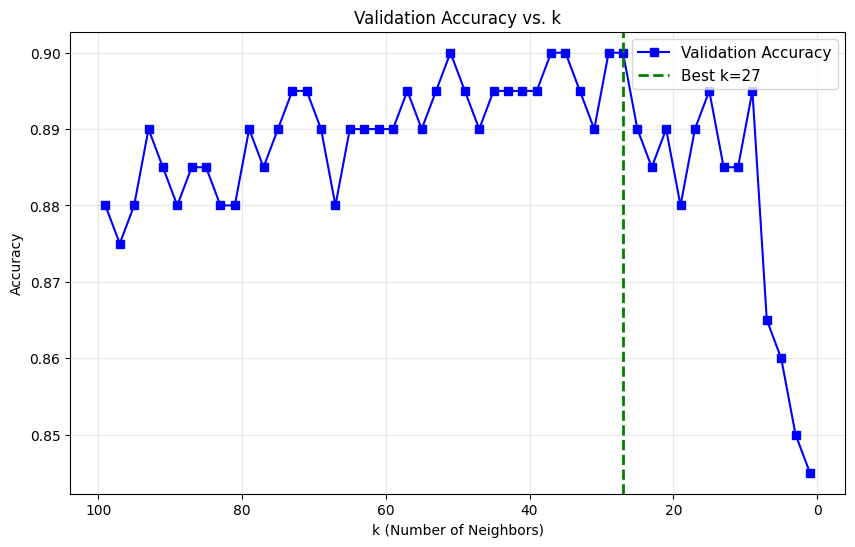

Best k: 27
Validation Accuracy: 0.9000


In [ ]:
# Define range of k (odd numbers to avoid ties)
k_values = np.arange(1, 100, 2)
val_scores = []

print("Searching for optimal k...")
for k in k_values:
    ### BEGIN SOLUTION
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_val, y_val)
    ### END SOLUTION
    val_scores.append(accuracy)

val_scores = np.array(val_scores)
best_k_idx = np.argmax(val_scores)
best_k = k_values[best_k_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, val_scores, marker='s', color='blue', label='Validation Accuracy')
plt.axvline(x=best_k, color='green', linestyle='--', linewidth=2, label=f'Best k={best_k}')
plt.title('Validation Accuracy vs. k')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

print(f"Best k: {best_k}")
print(f"Validation Accuracy: {val_scores[best_k_idx]:.4f}")

### 1.3. Train Final Model and Evaluate on Test Set

Now that we've selected the best $k$ using the validation set, we train a final model on the combined training+validation data with this optimal $k$, and evaluate it on the held-out test set.

#### Train and Evaluate the Final Model

Train a kNN classifier with best k on train+val data and evaluate on test set.


In [ ]:
# Combine train+val and train final model

X_final_train = np.vstack([X_train, X_val]) # The result will be of shape (n_train + n_val, n_features)
y_final_train = np.hstack([y_train, y_val]) # The result will be of shape (n_train + n_val,). Using hstack ensures that y remains a vector and does not become a 2D array.

### BEGIN SOLUTION
clf_final = KNeighborsClassifier(n_neighbors=best_k)
clf_final.fit(X_final_train, y_final_train)

# Evaluate on test set
y_pred = clf_final.predict(X_test)
test_accuracy = np.mean(y_pred == y_test)
### END SOLUTION

print(f"k: {best_k}")
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

k: 27
Final Test Accuracy: 0.8950 (89.50%)


---
## 2. Hyper-parameter Tuning via K-Fold Cross-Validation


We are going to tune the parameter k for kNN using k-fold cross-validation. We've already learned about `KNeighborsClassifier()` in Section 1. Now let's introduce `cross_val_score()`:

### `cross_val_score()` - K-Fold Cross-Validation

**Purpose:** Evaluate a model using k-fold cross-validation by computing accuracy scores across multiple folds.

**Syntax:**
```python
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    estimator,          # The model to evaluate (e.g., KNeighborsClassifier())
    X,                  # Feature matrix
    y,                  # Target labels
    cv=5,               # Number of folds (default=5)
    scoring='accuracy'  # Metric to use
)
```

**Returns:** Array of scores, one for each fold (e.g., `[0.92, 0.88, 0.90, 0.91, 0.89]`)

**How it works:**
1. Splits data into K non-overlapping folds
2. For each fold: trains on K-1 folds, validates on 1 fold
3. Returns accuracy scores for each fold
4. Average them to get robust estimate of model performance

### 2.1 Cross-validation and Grid Search with K-Fold Cross-Validation

We search over different values of $k$ by using 5-fold cross-validation on the training set. This finds the best hyperparameter without touching the test set.


Running k-fold cross-validation for each k...


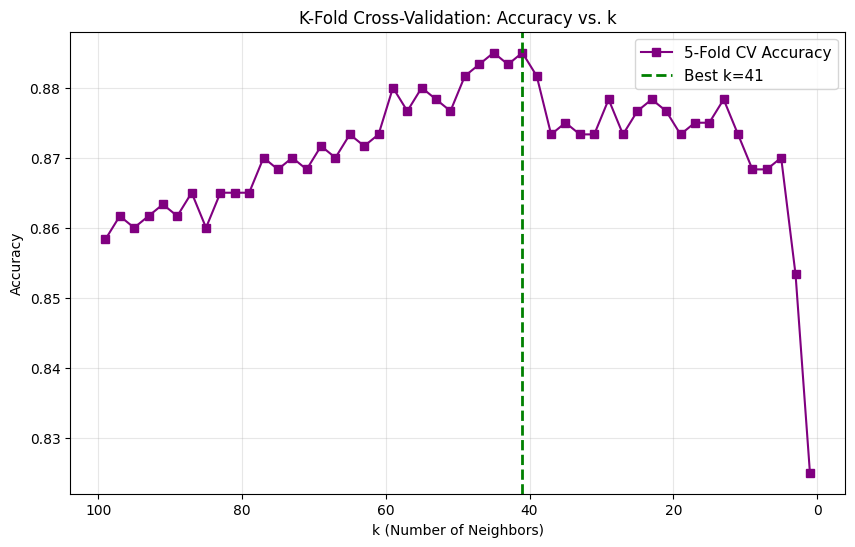

Best k: 41
Mean CV Accuracy: 0.8850


In [ ]:
# Define range of k (odd numbers to avoid ties)
k_values = np.arange(1, 100, 2)
val_scores = []

print("Running k-fold cross-validation for each k...")
for k in k_values:
    ### BEGIN SOLUTION
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    accuracy = scores.mean()
    ### END SOLUTION
    val_scores.append(accuracy)

val_scores = np.array(val_scores)
best_k_idx = np.argmax(val_scores)
best_k = k_values[best_k_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, val_scores, marker='s', color='purple', label='5-Fold CV Accuracy')
plt.axvline(x=best_k, color='green', linestyle='--', linewidth=2, label=f'Best k={best_k}')
plt.title('K-Fold Cross-Validation: Accuracy vs. k')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

print(f"Best k: {best_k}")
print(f"Mean CV Accuracy: {val_scores[best_k_idx]:.4f}")

### 2.2. Train Final Model and Evaluate on Test Set

Now that we've selected the best $k$ using 5-fold cross-validation on the training set, we train a final model on the full training data with this optimal $k$, and evaluate it on the held-out test set.


In [ ]:
# Train final model on training set with best k
### BEGIN SOLUTION
clf_final = KNeighborsClassifier(n_neighbors=best_k)
clf_final.fit(X_train, y_train)

# Evaluate on test set
y_pred = clf_final.predict(X_test)
test_accuracy = np.mean(y_pred == y_test)
### END SOLUTION

print(f"k: {best_k}")
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Best k: 41
Final Test Accuracy: 0.8800 (88.00%)
